# Домашнее задание 5

Решение каждой задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно. 
При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1 (10 pts)

Пусть задан набор из $N$ пар точек в $n$-мерном пространстве $x_1, \ldots , x_N$ и $y_1, \ldots, y_N$.
Также даны расстояния $d_1, \ldots , d_N$ между ними. Необходимо найти такую матрицу $M \in \mathbb{S}^n_+$, что 
$d_i \approx d(x_i, y_i) = \sqrt{(x_i − y_i)M(x_i − y_i)}$. 
Таким образом, целевой функцией в
данной задаче является следующая функция
$$ 
\min_{M \in \mathbb{S}^n_+} \frac{1}{N}\sum_{i=1}^N (d_i - d(x_i, y_i))^2.
$$

В данном случае при старте из точки $M_0 \in \mathbb{S}^n_+$ тестируемые методы не должен выводить промежуточные точки $M_k$ за границы допустимого множества, но не забудьте это проверять и модифицируйте размер шага соответственно.

Сравните сходимость градиентного спуска, метода тяжёлого шарика и быстрого градиентного метода для решения этой задачи.

Также проверьте ошибку на тестовых данных ```d_test, X_test, Y_test```. Прокомментируйте результат.

In [1]:
from scipy import linalg as la
import numpy as np
np.random.seed(8)

n = 5 # Dimension
N = 100 # Number of sample
N_test = 10 # Samples for test set

X = np.random.randn(n,N)
Y = np.random.randn(n,N)

X_test = np.random.randn(n,N_test)
Y_test = np.random.randn(n,N_test)

P = np.random.randn(n,n)
P = P.dot(P.T) + np.identity(n)
sqrtP = la.sqrtm(P)

d = np.linalg.norm(sqrtP.dot(X-Y),axis=0)
d = np.maximum(d+np.random.randn(N),0)
d_test = np.linalg.norm(sqrtP.dot(X_test-Y_test),axis=0)
d_test = np.maximum(d_test+np.random.randn(N_test),0)

- переберем параметры lr для GD, (alpha,beta) для HBM и alpha для Nesterov
- если на какой-то итерации x_new выходит из $S^n_{++}$, то режем параметры в из головы взятую константу раз
- используем те, которые дают самый быстрый спуск на train

In [125]:
import time
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import grad, jit, config
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
config.update("jax_enable_x64", True)

@jit
def f_train(M):
  diff = d-jnp.sqrt(jnp.einsum("ij,ij->i", jnp.dot(jnp.transpose(X), M), jnp.transpose(X)))
  return jnp.divide(jnp.dot(diff, diff),M.shape[0])
@jit
def f_test(M):
  diff = d_test-jnp.sqrt(jnp.einsum("ij,ij->i", jnp.dot(jnp.transpose(X_test), M), jnp.transpose(X_test)))
  return jnp.divide(jnp.dot(diff, diff),M.shape[0])


def grad_descent(params, x0, f, gradf, tol=1e-3, max_iter=10000, return_history=True):
  history = [(x0, f(x0), time.time())]
  lr = params['lr']
  x = x0.copy()
  k = 0
  while k == 0 or np.linalg.norm(gradf(x)) > tol: 
    x_new = x - lr*gradf(x)
    if np.isnan(x_new).any() or np.any(np.linalg.eigvals(x_new) < 1e-4):
        lr *= 0.8
        x_new = x
    x = x_new
    if return_history:
        history.append((x, f(x), time.time()))
    if k >= max_iter:
        break
    k += 1
  return x, history

def HBM(params, x0, f, gradf, tol=1e-3, max_iter=10000, return_history=True):
  history = [(x0, f(x0), time.time())]
  alpha, beta = params['alpha'], params['beta']
  x = x0.copy()
  k = 0
  x_prev = x0.copy()
  while k == 0 or np.linalg.norm(gradf(x)) > tol: 
      g = gradf(x)
      x_new = x - alpha * g + beta * (x - x_prev)
      if np.isnan(x_new).any() or np.any(np.linalg.eigvals(x_new) < 1e-4):
        x_new = x
        alpha *= 0.8
        beta  *= 0.8
      x_prev, x = x, x_new
      if return_history:
          history.append((x, f(x), time.time()))
      if k >= max_iter:
          break
      k += 1
  return x, history

def Nesterov(params, x0, f, gradf, tol=1e-3, max_iter=1000, return_history=True):
  history = [(x0, f(x0), time.time())]
  alpha = params['alpha']
  x = x0.copy()
  k = 0
  x_prev = x0.copy()
  y = x0.copy()
  while k == 0 or np.linalg.norm(gradf(x)) > tol: 
    x_new = y - alpha * gradf(y)
    if np.isnan(x_new).any() or np.any(np.linalg.eigvals(x_new) < 1e-4):
      x_new = x
      alpha *= 0.5
    x_prev, x = x, x_new
    y = x + k/(k+3) * (x - x_prev)
    if return_history:
      history.append((x, f(x), time.time()))
    if k >= max_iter:
        break
    k += 1
  return x, history

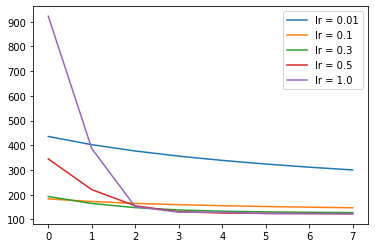

In [116]:
# Gradient descent
for i, lr in enumerate([0.01, 0.1, 0.3, 0.5, 1.0]):
  params = {'lr':lr}
  x, history = grad_descent(params, np.identity(n), f_train, grad(f_train), tol=1e-2)
  plt.plot([i[1] for i in history[2:10]], color = plt.cm.tab10(i), label = 'lr = ' + str(lr))
  plt.legend()

  for x, _, _ in history:
    assert(np.all(np.linalg.eigvals(x) > 1e-5))

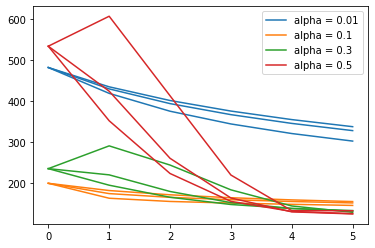

In [119]:
# HBM
for i, alpha in enumerate([0.01, 0.1, 0.3, 0.5]):
  for beta in [0.01, 0.1, 0.3]:
    params = {'alpha':alpha, 'beta':beta}
    x, history = HBM(params, np.identity(n), f_train, grad(f_train), tol=1e-2)
    plt.plot([i[1] for i in history[1:7]], color = plt.cm.tab10(i), label = 'alpha = ' + str(alpha) if beta == 0.01 else '')
    plt.legend()

    for x, _, _ in history:
      assert(np.all(np.linalg.eigvals(x) > 1e-5))

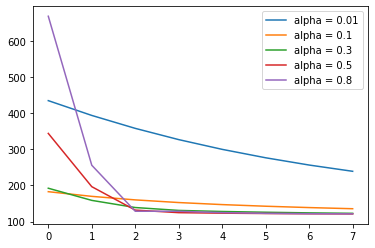

In [120]:
# Nesterov
for i, alpha in enumerate([0.01, 0.1, 0.3, 0.5, 0.8]):
  params = {'alpha':alpha}
  x, history = Nesterov(params, np.identity(n), f_train, grad(f_train), tol=1e-2)
  plt.plot([i[1] for i in history[2:10]], color = plt.cm.tab10(i), label = 'alpha = ' + str(alpha))
  plt.legend()

  for x, _, _ in history:
    assert(np.all(np.linalg.eigvals(x) > 1e-5))

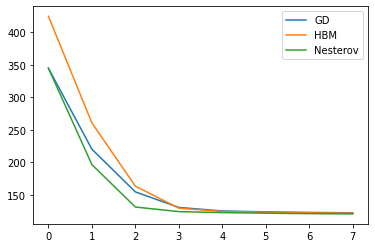

In [121]:
# COMPARE TRAIN

params = {'lr':0.5}
x, history = grad_descent(params, np.identity(n), f_train, grad(f_train), tol=1e-2)
plt.plot([i[1] for i in history[2:10]], label = 'GD')

params = {'alpha':0.5, 'beta':0.1}
x, history = HBM(params, np.identity(n), f_train, grad(f_train), tol=1e-2)
plt.plot([i[1] for i in history[2:10]], label = 'HBM')

params = {'alpha':0.5}
x, history = Nesterov(params, np.identity(n), f_train, grad(f_train), tol=1e-2)
plt.plot([i[1] for i in history[2:10]], label = 'Nesterov')
plt.legend();

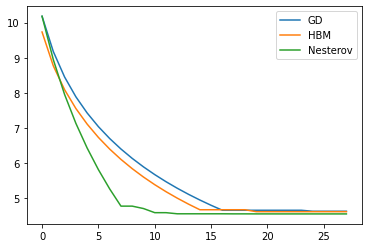

In [126]:
# COMPARE TEST

params = {'lr':0.5}
x, history = grad_descent(params, np.identity(n), f_test, grad(f_test), tol=1e-2)
plt.plot([i[1] for i in history[2:30]], label = 'GD')
for x, _, _ in history:
  assert(np.all(np.linalg.eigvals(x) > 1e-5))

params = {'alpha':0.5, 'beta':0.1}
x, history = HBM(params, np.identity(n), f_test, grad(f_test), tol=1e-2)
plt.plot([i[1] for i in history[2:30]], label = 'HBM')
for x, _, _ in history:
  assert(np.all(np.linalg.eigvals(x) > 1e-5))

params = {'alpha':0.5}
x, history = Nesterov(params, np.identity(n), f_test, grad(f_test), tol=1e-2)
plt.plot([i[1] for i in history[2:30]], label = 'Nesterov')
for x, _, _ in history:
  assert(np.all(np.linalg.eigvals(x) > 1e-5))
plt.legend();

- HBM оказался самым чувствительным к подбору гиперпараметров, в то время как Nesterov и GD(fixed lr) - одинаково устойчивы по гиперпараметру
- Nesterov показал лучшие результаты.

Что можно улучшить?
- все что угодно, начиная с более тщательного перебора параметров (включая монте-карло на разных сидах) и заканчивая анализом аналитического решения и поиска $L, \mu$ 

## Задача 2 (10 pts)

- (2 pts) Покажите, что градиенты, полученные на двух последовательных шагах градиентного спуска с использованием правила наискорейшего спуска, ортогональны.

- (5 pts) Докажите, что если целевая функция $f(x) = \frac{1}{2}x^{\top}Qx - b^{\top}x$, $Q \in \mathbb{S}^n_{++}$, шаг определяется с помощью наискорейшего спуска и $x^0 - x^*$ параллелен собственному вектору матрицу $Q$, то градиентный спуск сходится за один шаг. 

- Покажите, что для $f(x) = x^{\top}x$ градиентный спуск с выбором шага по правилу наискорейшего спуска сходится за одну итерацию:
    - (1 pts) с использованием предыдущего утверждения
    - (2 pts) прямым вычислением 

In [127]:
# решение:

1) $x_1 = x_0-a_1\nabla f(x_0),\quad a_{\min}=\arg\min\limits_af(x_0-a\nabla f(x_0))\Rightarrow -\nabla f(x_0-a_{\min}\nabla f(x_0))\cdot\nabla f(x_0)=0=(\nabla f(x_0), \nabla f(x_1))$, чтд

2) $\nabla f = Qx-b,\ Q(x_0-x^*)=Qx_0-b=\lambda x_0-\lambda Q^{-1}b;\quad (\nabla f(x_0), \nabla f(x_1))=(Qx_0-b, Q[x_0-a_1(Qx_0-b)]-b)=0$
- $Q[x_0-a_1(Qx_0-b)]-b=Qx_0-a_1Q(\lambda x_0-\lambda Q^{-1}b)-b=(1-\lambda a_1)Qx_0+\lambda a_1b-b=(1-\lambda a_1)(Qx_0-b)\Rightarrow$
- $(\nabla f(x_0), \nabla f(x_1)) = (1-\lambda a_1)\|Qx_0-b\|=0\Rightarrow \nabla f(x_1)=0$, чтд

3) a) $x_0-x^*=x_0$ - собств. вектор единичной матрицы, чтд\
b) $\nabla f=2x\Rightarrow a_{\min}=\arg\min\limits_a((1-2a)x_0, (1-2a)x_0)=0.5\Rightarrow x_1=x_0-x_0=0$, чтд

## Задача 3 (15 pts)

- (5 pts) Оцените константу Липшица градиента для функции

$$
f(w) = \frac12 \|w\|_2^2 + C \frac1m \sum_{i=1}^m \log (1 + \exp(- y_i \langle x_i, w \rangle)) \to \min_w
$$

- (10 pts) Используя найденное значение сравните сходимость метода тяжёлого шарика, метод градиентного спуска с оптимальным постоянным шагом и быстрый градиентный метод. Сделайте вывод о точности оценки констант и их влиянии на скорость сходимости метода тяжёлого шарика. Векторы $x_i$ и скаляры $y_i$ геенрируются кодом ниже.

In [ ]:
n = 300
m = 1000
import sklearn.datasets as skldata

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1

In [ ]:
# Место для вашего решения

1)
- $\nabla f= w + \dfrac Cm\sum -y_iw \dfrac{\exp(- y_i \langle x_i, w \rangle)}{1+\exp(- y_i \langle x_i, w \rangle)}=w(1+S),\ S=-\dfrac Cm\sum y_i \dfrac{\exp(- y_i \langle x_i, w \rangle)}{1+\exp(- y_i \langle x_i, w \rangle)}\Rightarrow |S|\leq C \max(|y_{\min}|,|y_{\max}|)\Rightarrow$
- $\|\nabla f(x)-\nabla f(y)\|=\|x(1+S_x)-y(1+S_y)\|\leq 2[1+C \max(|y_{\min}|,|y_{\max}|)]\|x-y\|$ (но так не работает, к сожалению)



2)
- не успел